回帰

252で重要度の低い特徴量を恣意的に減らす



## 必要なライブラリのimport

In [1]:
import warnings
import time
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [19]:
# データの読み込み
path_train = '../../../../data/extornal/train_processed_clv&churn.csv'
train_all = pd.read_csv(path_train)

# 目的変数と説明変数の作成
target = train_all['target']
del train_all['target']

features_all = pd.read_csv('../../../../data/processed/features_52_all.csv')

#train = train.astype({col: 'float' for col in train.select_dtypes(include='int').columns})


上位25％以上

In [20]:
# 特徴量の選択
pct25 = features_all['importance'].quantile(0.25)
pct50 = features_all['importance'].quantile(0.5)
pct75 = features_all['importance'].quantile(0.75)

features_selected = features_all.query('importance > @pct25').reset_index(drop=True)

selected_columns = features_selected['feature'].tolist()
train = train_all[selected_columns]


In [6]:
train

,total_date_min,new_frequency_rmf,new_purchase_amount_mean,new_transactions_count,new_subsector_id_nunique,total_day_min,installments_count_std,hist_amount_mean,new_amount_mean,auth_state_id_nunique,category_1_installments_min,hist_amount_max,hist_amount_month_ratio_mean,auth_category_2_5.0_mean,hist_ratio_Yes,feature_var,hist_duration_mean,total_day_max,total_amount_mean,category_1_purchase_amount_mean,auth_purchase_month_max,installments_purchase_amount_mean,new_purchase_amount_min,new_installments_mean_y,auth_purchase_month_min,auth_category_2_4.0_mean,total_price_max,history_category_3_1.0_mean,hist_duration_max,history_city_id_nunique,feature_sum,hist_amount_month_ratio_max,hist_day_max,installments_count_mean,new_category_2_1.0_mean,total_amount_month_ratio_mean,history_purchase_month_min,total_duration_mean,total_state_mode,quarter,hist_city_nu,new_merchant_category_id_nunique,total_city_nu,installments_min_mean,total_amount_total,auth_city_id_nunique,total_amount_min,total_day_nu,history_purchase_month_max,new_weekend_mean,category_1_purchase_amount_max,hist_month_lag_median,history_month_lag_max,history_state_id_nunique,total_price_min,hist_price_sum,history_subsector_id_nunique,new_state_mode,hist_day_nu,auth_installments_std,history_category_3_3.0_mean,auth_installments_mean,new_amount_min,auth_purchase_amount_max,feature_1,total_month_lag_median,hist_state_mode,installments_mean_mean,hist_count_No,installments_purchase_amount_std,city_id_purchase_amount_mean,installments_max_mean,installments_purchase_amount_max,new_price_mean,new_installments_std,total_amount_month_ratio_min,category_1_installments_std,history_merchant_id_nunique,hist_installments_mean,installments_max_std,history_month_lag_min,new_month_lag_std,auth_subsector_id_nunique,history_merchant_category_id_nunique,new_purchase_month_min,category_1_purchase_amount_std,auth_merchant_category_id_nunique,auth_purchase_amount_min,new_price_max,total_installments_mean,hist_amount_total,new_duration,new_amount_median,hist_frequency,installments_min_std,installments_mean_std,new_amount_month_ratio_min,days_feature3_ratio,new_month_lag_mean_y,new_category_1_sum,total_merchant_category_nu,hist_merchant_category_nu,new_amount_month_ratio_mean,history_installments_mean,auth_purchase_amount_std,installments_std_mean,total_city_mode,total_frequency,new_month_diff_mean,category_1_purchase_amount_min,installments_sum_mean,ratio_amount_mean,auth_transactions_count,hist_monetary_value,auth_category_3_3.0_mean,new_category_3_2.0_mean,history_category_2_1.0_mean,new_purchase_month_max,installments_sum_std,city_id_purchase_amount_min,auth_purchase_amount_mean,new_price_min,total_recency_rfm,total_installments_sum,auth_installments_sum,city_id_purchase_amount_max,hist_price_min,hist_price_max,hist_date_min,new_amount_total,hist_price_mean,total_monetary_value,first_active_month,history_category_3_2.0_mean,auth_purchase_amount_sum,installments_purchase_amount_min,hist_merchant_category_mode,new_duration_mean,hist_city_mode,new_clv,new_city_mode,new_merchant_category_mode,city_id_purchase_amount_std,total_duration,new_price_sum,purchase_amount_max_std,hist_frequency_rmf,hist_duration_min,total_merchant_category_mode,auth_category_3_2.0_mean,new_amount_max,hist_amount_month_ratio_min,total_predicted_monetary_value,total_duration_min,hist_weekend_mean,installments_std_std,history_category_1_mean,new_purchase_month_std,new_weekday_mean,new_purchase_amount_max,purchase_amount_mean_mean,purchase_amount_mean_std,hist_recency_rmf,purchase_amount_count_std,new_date_min,history_purchase_amount_max,total_frequency_rfm,auth_category_2_1.0_mean,total_price_sum,total_weekend_mean,days_feature3,new_predicted_monetary_value,hist_installments_sum,history_purchase_amount_mean,new_duration_min,auth_merchant_id_nunique,hist_weekday_mean,purchase_amount_std_mean,history_installments_std,purchase_amount_min_mean,purchase_amount_count_mean,purchase_amount_sum_std,hist_duration,new_amount_month_ratio

In [10]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id']]
categorical_feats = []
#['feature_1','feature_2', 'feature_3',]
# 'hist_merchant_category_mode','hist_city_mode','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod',
# 'total_merchant_category_mode','total_city_mode','total_state_mode','total_category_1_mod','total_category_2_mod','total_category_3_mod',
# 'new_merchant_category_mode','new_city_mode','new_state_mode','new_category_1_mod','new_category_2_mod','new_category_3_mod']

In [7]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [11]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_60_25/', exist_ok=True)
    with open(f'../src/models/lgb_60_25/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.71044
[200]	valid_0's rmse: 3.66122
[300]	valid_0's rmse: 3.63797
[400]	valid_0's rmse: 3.62469
[500]	valid_0's rmse: 3.61763
[600]	valid_0's rmse: 3.6135
[700]	valid_0's rmse: 3.61057
[800]	valid_0's rmse: 3.60884
[900]	valid_0's rmse: 3.6074
[1000]	valid_0's rmse: 3.60647
[1100]	valid_0's rmse: 3.60604
[1200]	valid_0's rmse: 3.60491
[1300]	valid_0's rmse: 3.60449
[1400]	valid_0's rmse: 3.60407
[1500]	valid_0's rmse: 3.6035
[1600]	valid_0's rmse: 3.60336
[1700]	valid_0's rmse: 3.60319
[1800]	valid_0's rmse: 3.60338
Early stopping, best iteration is:
[1660]	valid_0's rmse: 3.60305
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.74305
[200]	valid_0's rmse: 3.69357
[300]	valid_0's rmse: 3.66997
[400]	valid_0's rmse: 3.65729
[500]	valid_0's rmse: 3.65039
[600]	valid_0's rmse: 3.6464
[700]	valid_0's rmse: 3.64341
[800]	valid_0's rmse: 3.64193
[900]	v

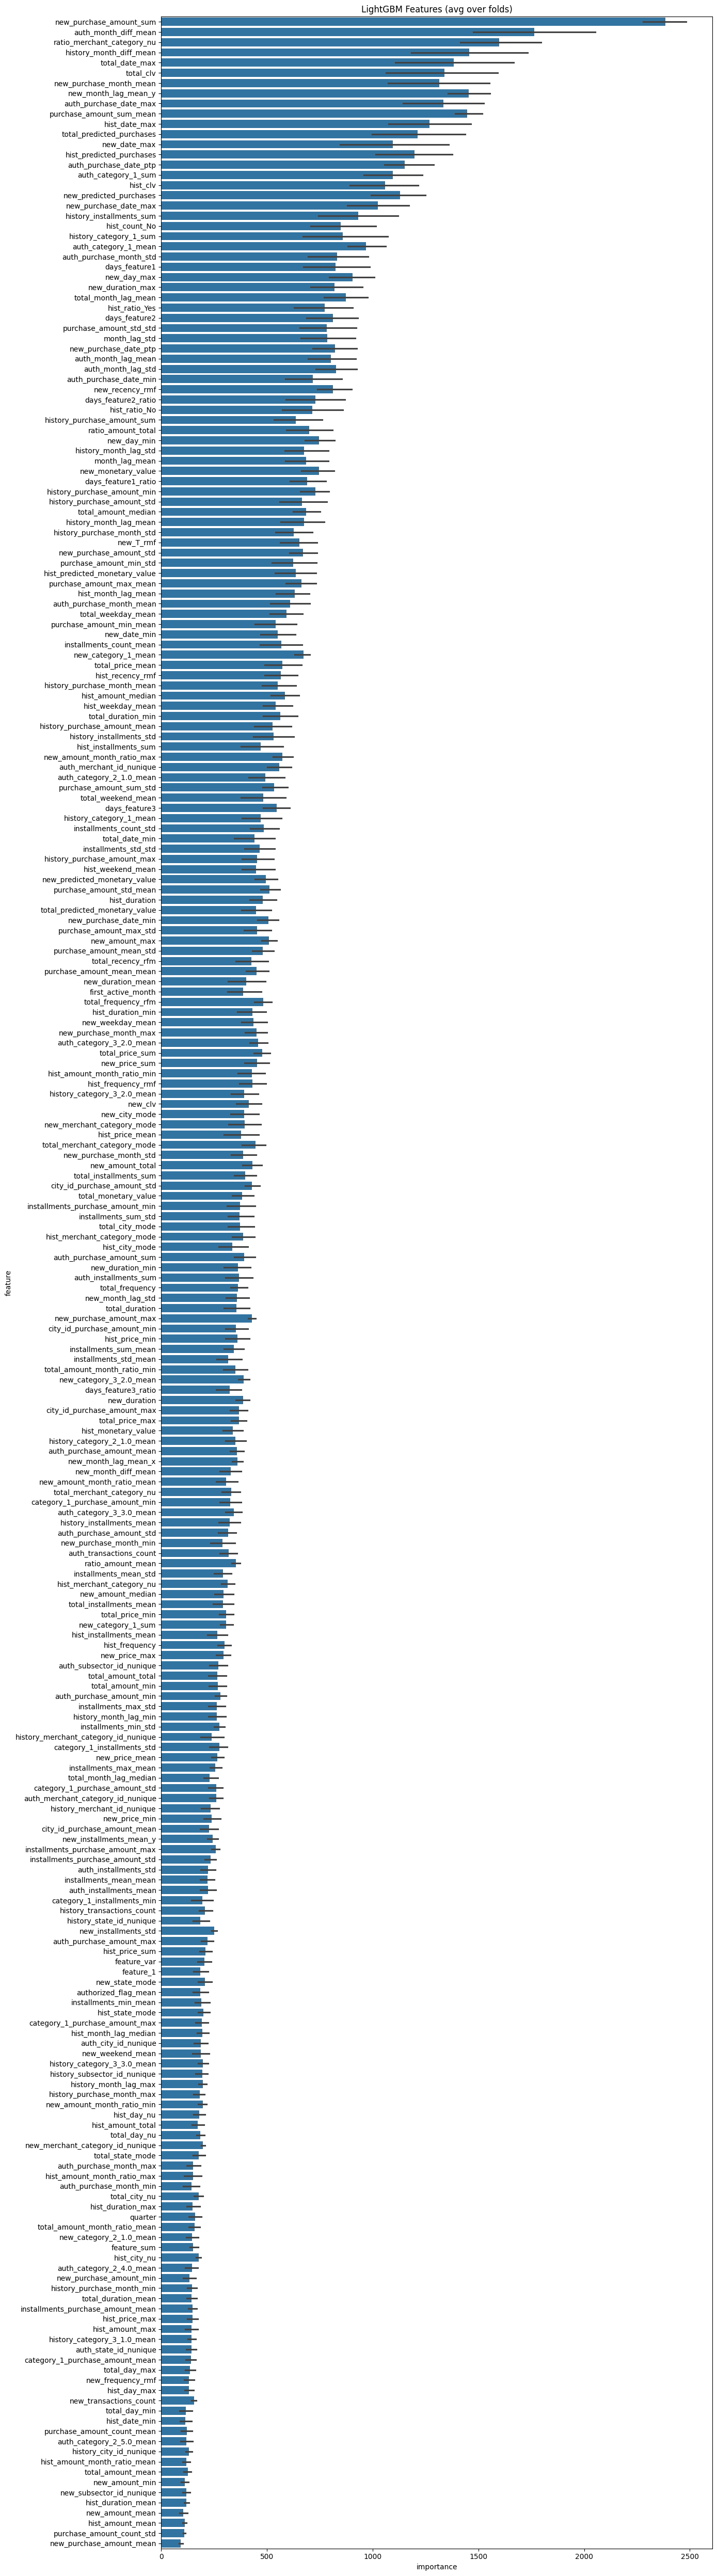

In [12]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

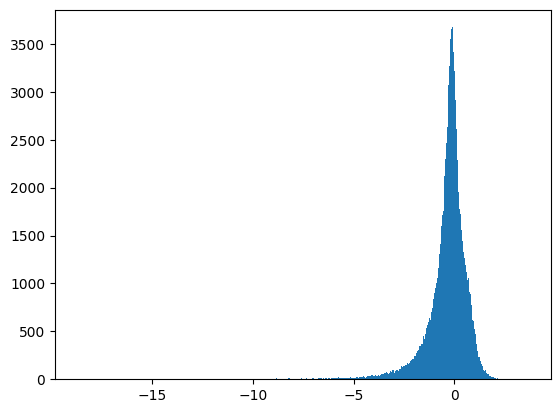

In [13]:
plt.hist(oof[oof<2**8],bins=1000)

上位50%以上

In [21]:
features_selected = features_all.query('importance > @pct50').reset_index(drop=True)

selected_columns = features_selected['feature'].tolist()
train = train_all[selected_columns]

# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id']]
categorical_feats = []

In [22]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_60_50/', exist_ok=True)
    with open(f'../src/models/lgb_60_50/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.7094
[200]	valid_0's rmse: 3.66046
[300]	valid_0's rmse: 3.63675
[400]	valid_0's rmse: 3.62419
[500]	valid_0's rmse: 3.61717
[600]	valid_0's rmse: 3.61319
[700]	valid_0's rmse: 3.61001
[800]	valid_0's rmse: 3.60825
[900]	valid_0's rmse: 3.60681
[1000]	valid_0's rmse: 3.60575
[1100]	valid_0's rmse: 3.60502
[1200]	valid_0's rmse: 3.60442
[1300]	valid_0's rmse: 3.60411
[1400]	valid_0's rmse: 3.60389
[1500]	valid_0's rmse: 3.60373
[1600]	valid_0's rmse: 3.60385
[1700]	valid_0's rmse: 3.6035
[1800]	valid_0's rmse: 3.60359
[1900]	valid_0's rmse: 3.60355
Early stopping, best iteration is:
[1774]	valid_0's rmse: 3.6034
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.74287
[200]	valid_0's rmse: 3.69343
[300]	valid_0's rmse: 3.66885
[400]	valid_0's rmse: 3.65624
[500]	valid_0's rmse: 3.64919
[600]	valid_0's rmse: 3.64504
[700]	valid_0's rmse: 3.64231
[800]

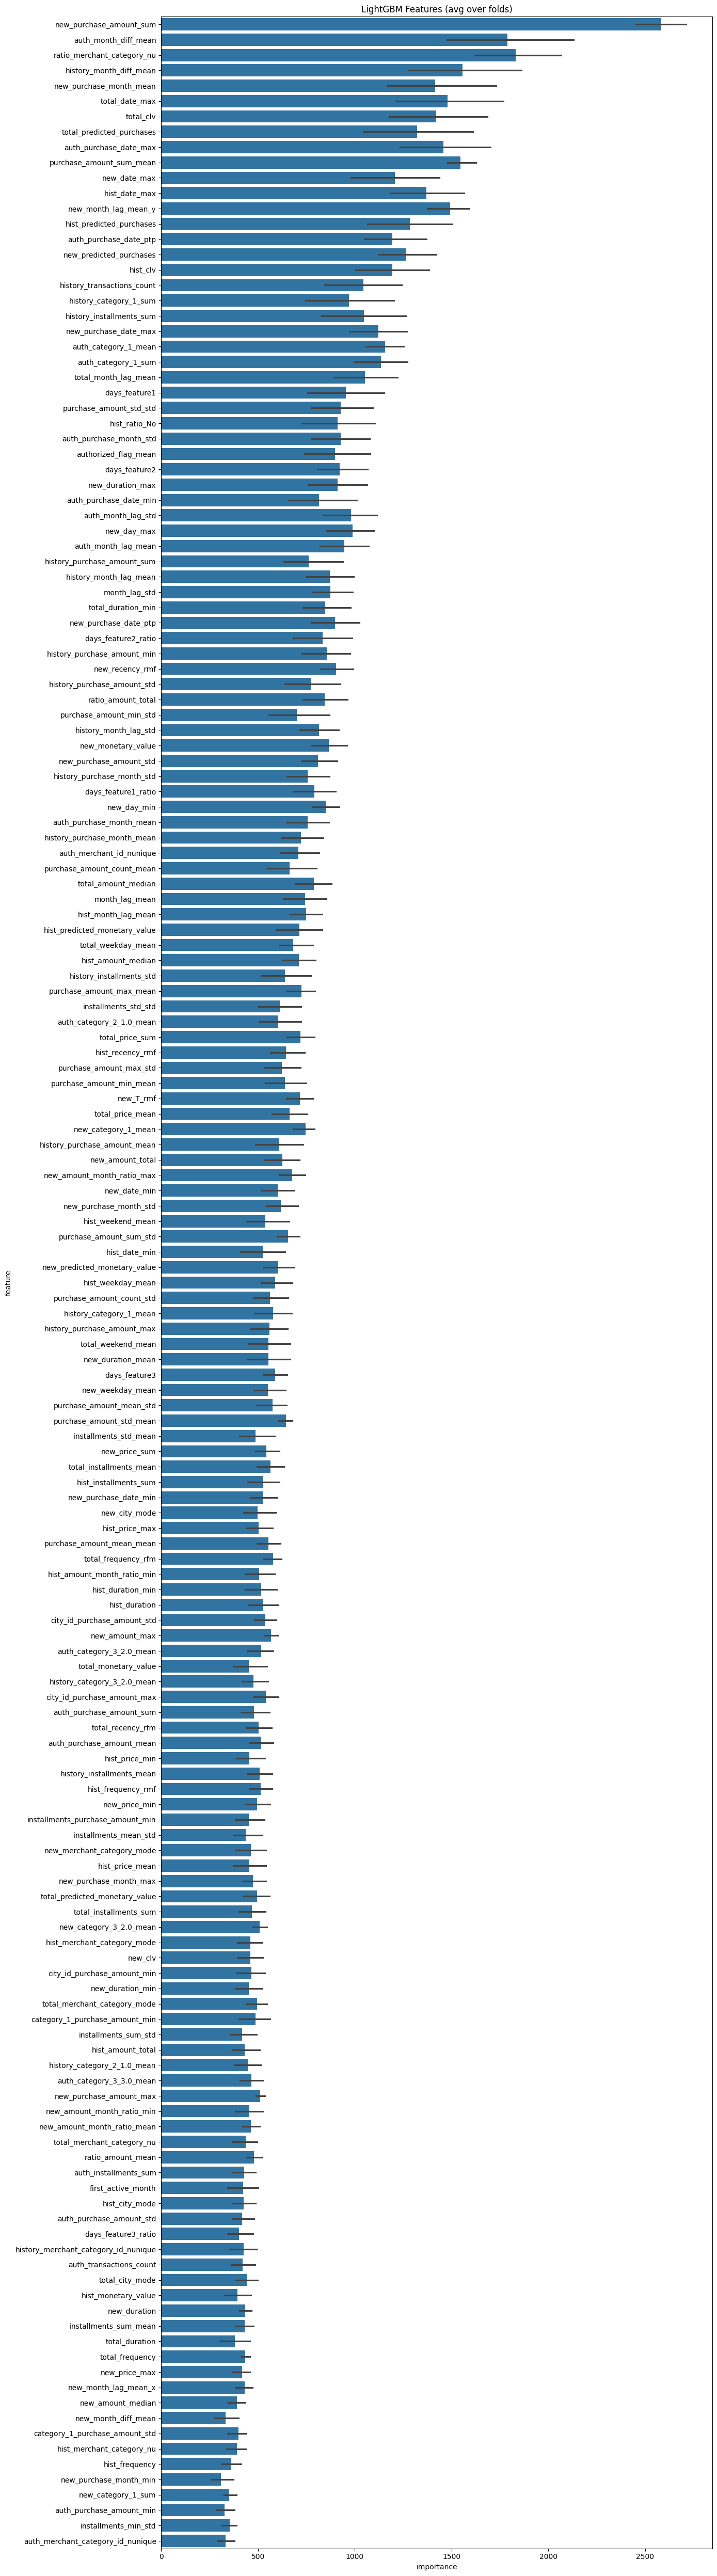

In [23]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

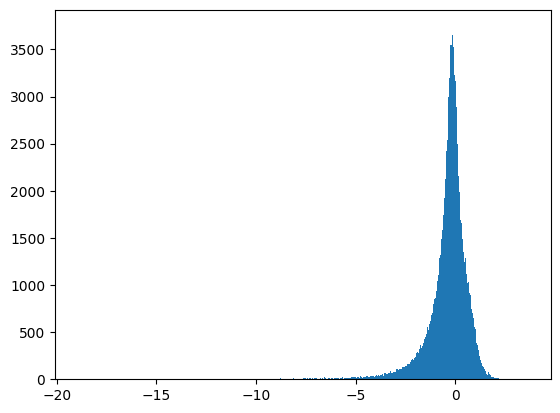

In [24]:
plt.hist(oof[oof<2**8],bins=1000)

上位75%以上

In [39]:
features_selected = features_all.query('importance > @pct75').reset_index(drop=True)

selected_columns = features_selected['feature'].tolist()
train = train_all[selected_columns]

# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id']]
categorical_feats = []


In [26]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_60_75/', exist_ok=True)
    with open(f'../src/models/lgb_60_75/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.71005
[200]	valid_0's rmse: 3.66233
[300]	valid_0's rmse: 3.63796
[400]	valid_0's rmse: 3.6258
[500]	valid_0's rmse: 3.6187
[600]	valid_0's rmse: 3.61511
[700]	valid_0's rmse: 3.61237
[800]	valid_0's rmse: 3.61068
[900]	valid_0's rmse: 3.60966
[1000]	valid_0's rmse: 3.6091
[1100]	valid_0's rmse: 3.60867
[1200]	valid_0's rmse: 3.60851
[1300]	valid_0's rmse: 3.60835
[1400]	valid_0's rmse: 3.60834
[1500]	valid_0's rmse: 3.60821
[1600]	valid_0's rmse: 3.60859
Early stopping, best iteration is:
[1461]	valid_0's rmse: 3.60812
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.74332
[200]	valid_0's rmse: 3.69327
[300]	valid_0's rmse: 3.66945
[400]	valid_0's rmse: 3.65703
[500]	valid_0's rmse: 3.64978
[600]	valid_0's rmse: 3.64583
[700]	valid_0's rmse: 3.64365
[800]	valid_0's rmse: 3.64231
[900]	valid_0's rmse: 3.64128
[1000]	valid_0's rmse: 3.64099
[1100]	

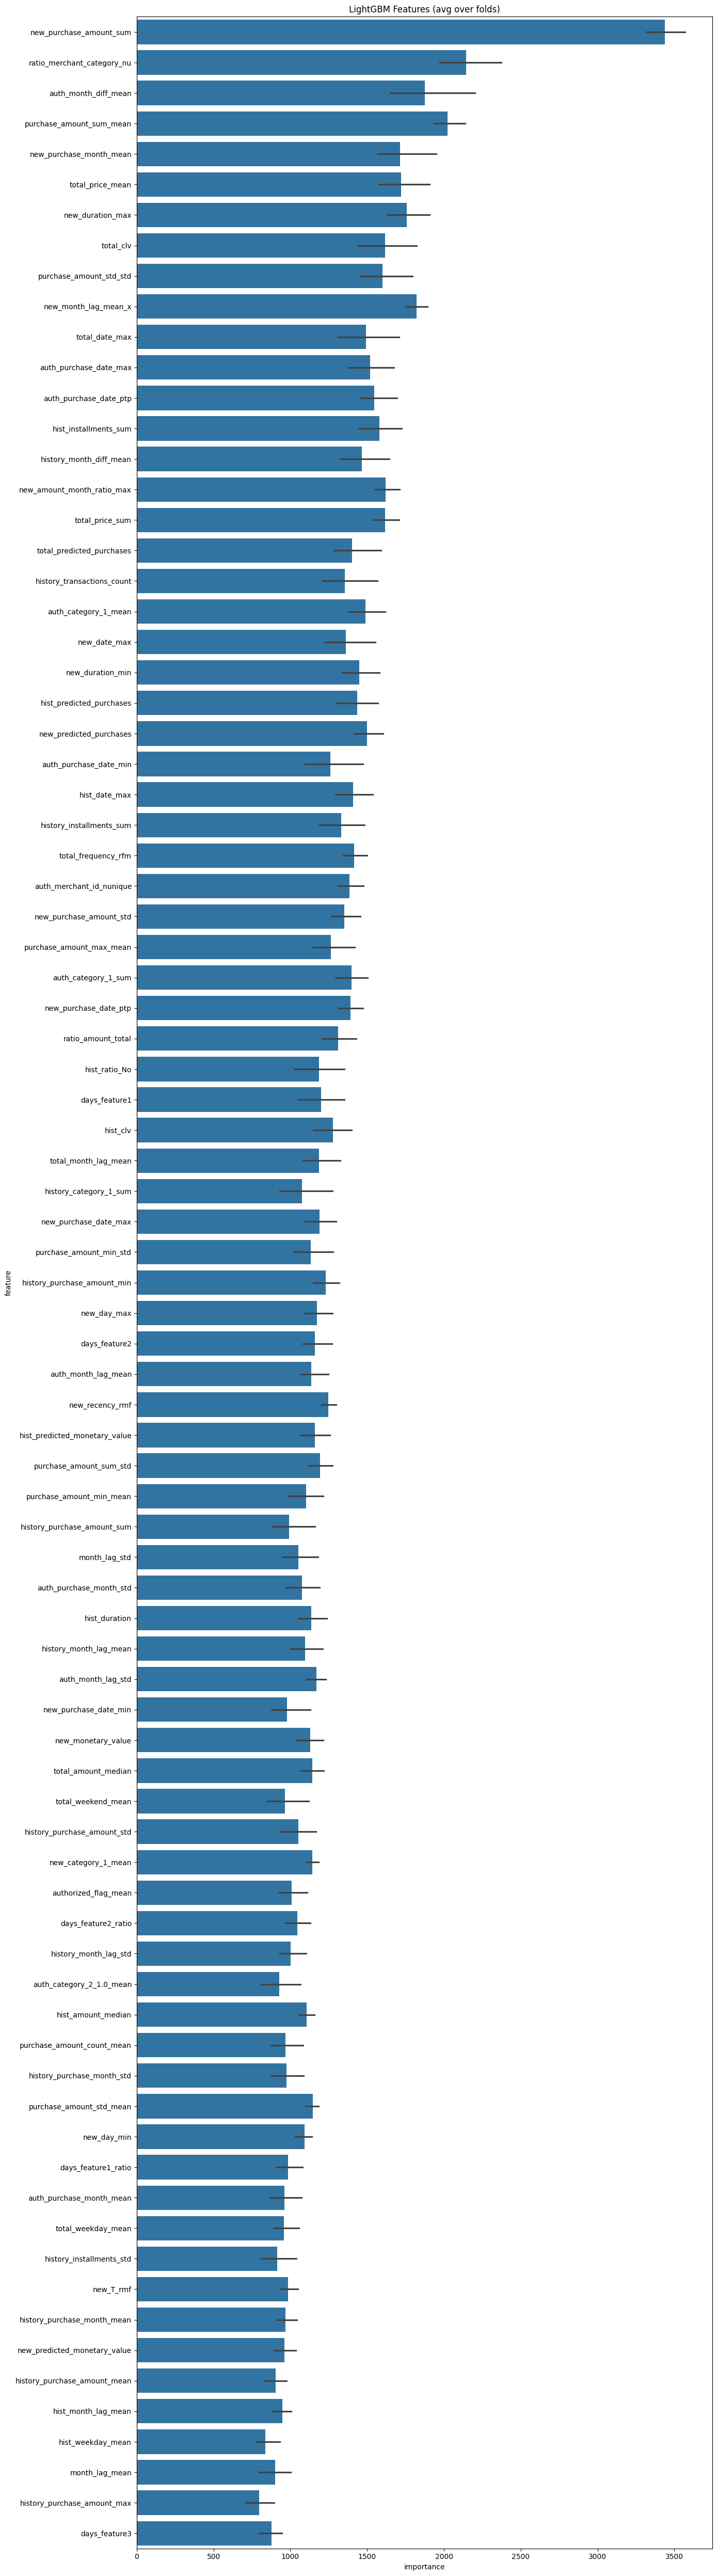

In [27]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

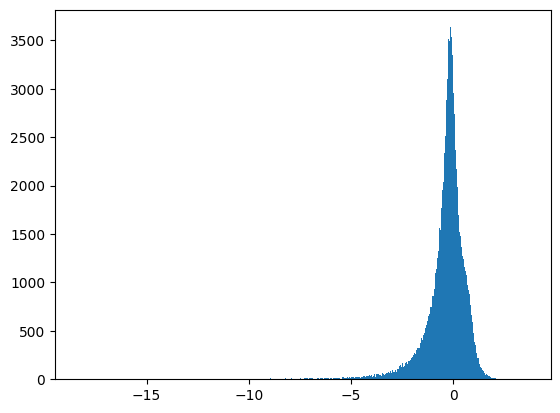

In [28]:
plt.hist(oof[oof<2**8],bins=1000)

In [40]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_60_75_2/', exist_ok=True)
    with open(f'../src/models/lgb_60_75_2/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.71005
[200]	valid_0's rmse: 3.66233
[300]	valid_0's rmse: 3.63796
[400]	valid_0's rmse: 3.6258
[500]	valid_0's rmse: 3.6187
[600]	valid_0's rmse: 3.61511
[700]	valid_0's rmse: 3.61237
[800]	valid_0's rmse: 3.61068
[900]	valid_0's rmse: 3.60966
[1000]	valid_0's rmse: 3.6091
[1100]	valid_0's rmse: 3.60867
[1200]	valid_0's rmse: 3.60851
[1300]	valid_0's rmse: 3.60835
[1400]	valid_0's rmse: 3.60834
[1500]	valid_0's rmse: 3.60821
[1600]	valid_0's rmse: 3.60859
Early stopping, best iteration is:
[1461]	valid_0's rmse: 3.60812
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.74332
[200]	valid_0's rmse: 3.69327
[300]	valid_0's rmse: 3.66945
[400]	valid_0's rmse: 3.65703
[500]	valid_0's rmse: 3.64978
[600]	valid_0's rmse: 3.64583
[700]	valid_0's rmse: 3.64365
[800]	valid_0's rmse: 3.64231
[900]	valid_0's rmse: 3.64128
[1000]	valid_0's rmse: 3.64099
[1100]	

In [29]:
pct30 = features_all['importance'].quantile(0.3)
pct40 = features_all['importance'].quantile(0.4)

上位30％以上

In [30]:
features_selected = features_all.query('importance > @pct30').reset_index(drop=True)

selected_columns = features_selected['feature'].tolist()
train = train_all[selected_columns]

# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id']]
categorical_feats = []


In [32]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_60_30/', exist_ok=True)
    with open(f'../src/models/lgb_60_30/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.7102
[200]	valid_0's rmse: 3.66149
[300]	valid_0's rmse: 3.63774
[400]	valid_0's rmse: 3.6256
[500]	valid_0's rmse: 3.61875
[600]	valid_0's rmse: 3.614
[700]	valid_0's rmse: 3.6112
[800]	valid_0's rmse: 3.60952
[900]	valid_0's rmse: 3.6084
[1000]	valid_0's rmse: 3.60785
[1100]	valid_0's rmse: 3.6069
[1200]	valid_0's rmse: 3.60614
[1300]	valid_0's rmse: 3.60545
[1400]	valid_0's rmse: 3.60547
[1500]	valid_0's rmse: 3.6051
[1600]	valid_0's rmse: 3.60491
[1700]	valid_0's rmse: 3.60453
[1800]	valid_0's rmse: 3.60456
[1900]	valid_0's rmse: 3.60459
[2000]	valid_0's rmse: 3.60462
Early stopping, best iteration is:
[1835]	valid_0's rmse: 3.60445
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.7437
[200]	valid_0's rmse: 3.6942
[300]	valid_0's rmse: 3.67053
[400]	valid_0's rmse: 3.658
[500]	valid_0's rmse: 3.65083
[600]	valid_0's rmse: 3.64674
[700]	valid_0

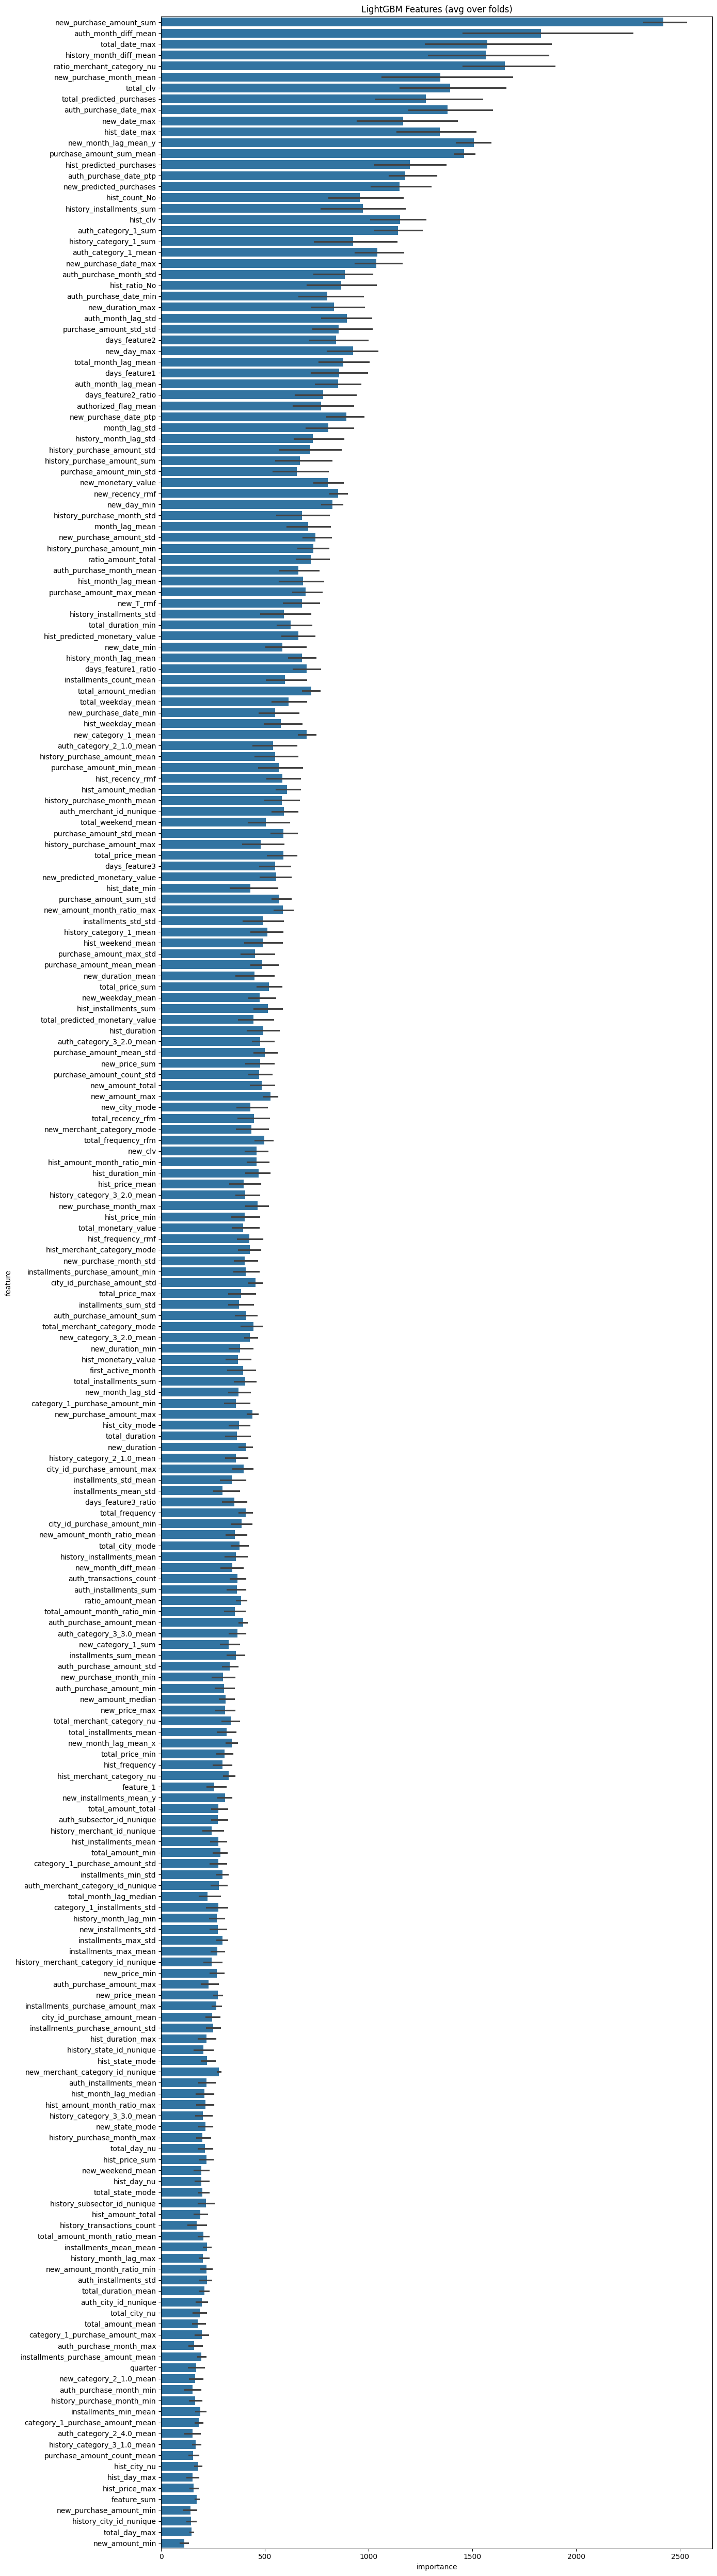

In [33]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

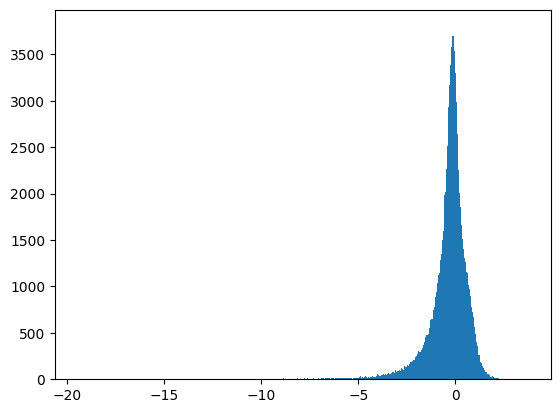

In [34]:
plt.hist(oof[oof<2**8],bins=1000)

上位40％以上

In [35]:
features_selected = features_all.query('importance > @pct40').reset_index(drop=True)

selected_columns = features_selected['feature'].tolist()
train = train_all[selected_columns]

# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id']]
categorical_feats = []


In [36]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_60_40/', exist_ok=True)
    with open(f'../src/models/lgb_60_40/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.70981
[200]	valid_0's rmse: 3.66108
[300]	valid_0's rmse: 3.63762
[400]	valid_0's rmse: 3.62459
[500]	valid_0's rmse: 3.61758
[600]	valid_0's rmse: 3.61348
[700]	valid_0's rmse: 3.61048
[800]	valid_0's rmse: 3.60895
[900]	valid_0's rmse: 3.60759
[1000]	valid_0's rmse: 3.60667
[1100]	valid_0's rmse: 3.60615
[1200]	valid_0's rmse: 3.60559
[1300]	valid_0's rmse: 3.60508
[1400]	valid_0's rmse: 3.60493
[1500]	valid_0's rmse: 3.60478
[1600]	valid_0's rmse: 3.60481
Early stopping, best iteration is:
[1446]	valid_0's rmse: 3.60462
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.74346
[200]	valid_0's rmse: 3.6935
[300]	valid_0's rmse: 3.66966
[400]	valid_0's rmse: 3.65722
[500]	valid_0's rmse: 3.65042
[600]	valid_0's rmse: 3.64607
[700]	valid_0's rmse: 3.64352
[800]	valid_0's rmse: 3.64147
[900]	valid_0's rmse: 3.63985
[1000]	valid_0's rmse: 3.63869
[1100

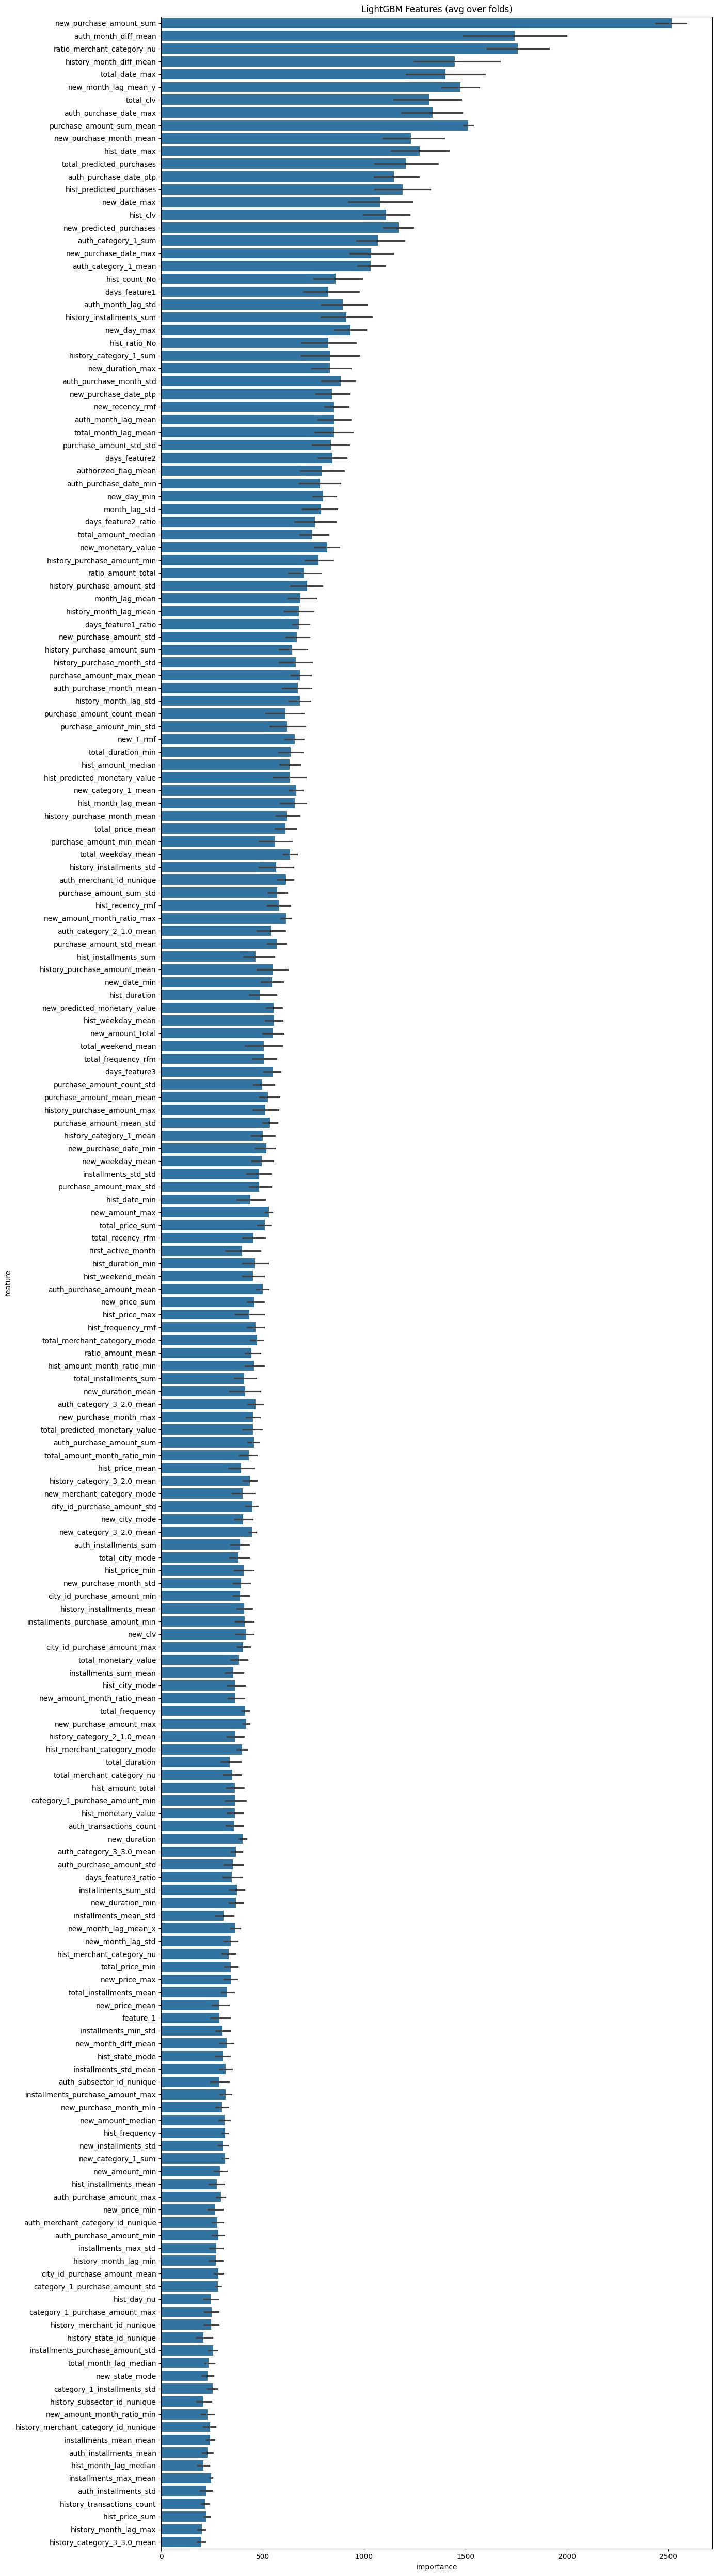

In [37]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

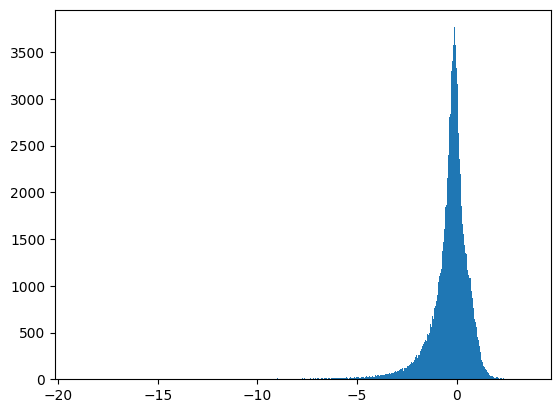

In [38]:
plt.hist(oof[oof<2**8],bins=1000)

In [41]:
res = []
for i in [26,27]:
    pct = features_all['importance'].quantile(i/100)
    features_selected = features_all.query('importance > @pct').reset_index(drop=True)

    selected_columns = features_selected['feature'].tolist()
    train = train_all[selected_columns]

    # 特徴量の情報
    features = [c for c in train.columns if c not in ['card_id']]
    categorical_feats = []


    # データをKFoldで5分割して学習
    folds = KFold(n_splits=5, shuffle=True, random_state=26)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(target))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                            label=target.iloc[trn_idx],
                            categorical_feature=categorical_feats
                            )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                            label=target.iloc[val_idx],
                            categorical_feature=categorical_feats
                            )

        num_round = 10000
        clf = lgb.train(
                        params = param,
                        train_set=trn_data,
                        num_boost_round=num_round,
                        valid_sets=[val_data],
                        callbacks=[lgb.early_stopping(stopping_rounds=200),
                                lgb.log_evaluation(100)],
                        )

        #clf = lgb.train(param, trn_data)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # モデルを保存
        os.makedirs(f'../src/models/lgb_60_{i}/', exist_ok=True)
        with open(f'../src/models/lgb_60_{i}/model_fold_{fold_}.pkl', 'wb') as f:
            pickle.dump(clf, f)

    print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
    res.append(mean_squared_error(oof, target)**0.5)

print(res)

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.70957
[200]	valid_0's rmse: 3.66075
[300]	valid_0's rmse: 3.63729
[400]	valid_0's rmse: 3.62487
[500]	valid_0's rmse: 3.61765
[600]	valid_0's rmse: 3.61353
[700]	valid_0's rmse: 3.61095
[800]	valid_0's rmse: 3.60908
[900]	valid_0's rmse: 3.60747
[1000]	valid_0's rmse: 3.60639
[1100]	valid_0's rmse: 3.60592
[1200]	valid_0's rmse: 3.60542
[1300]	valid_0's rmse: 3.60485
[1400]	valid_0's rmse: 3.60477
[1500]	valid_0's rmse: 3.60442
[1600]	valid_0's rmse: 3.60427
[1700]	valid_0's rmse: 3.60392
[1800]	valid_0's rmse: 3.60387
[1900]	valid_0's rmse: 3.60396
Early stopping, best iteration is:
[1772]	valid_0's rmse: 3.60365
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.7429
[200]	valid_0's rmse: 3.69353
[300]	valid_0's rmse: 3.66917
[400]	valid_0's rmse: 3.65638
[500]	valid_0's rmse: 3.64938
[600]	valid_0's rmse: 3.64537
[700]	valid_0's rmse: 3.64251
[80